In [2]:
import numpy as np
import ast
import pandas as pd
import os
import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
import cvxpy as cp
import itertools
import networkx as nx
import plotly.express as px

from scipy.special import logsumexp

%matplotlib inline
# sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/dev/vivarium-ecoli'))

from ecoli.processes.metabolism_redux_classic import NetworkFlowModel, FlowResult
from ecoli.library.schema import numpy_schema, bulk_name_to_idx, listener_schema, counts
from ecoli.processes.registries import topology_registry
TOPOLOGY = topology_registry.access("ecoli-metabolism-redux")

In [19]:
# load basal new model
time = '2400'
date = '2025-04-02'
experiment = 'NEW'
condition = 'basal'
entry = f'{experiment}_{time}_{date}'
folder = f'out/metabolism-comparison/{condition}/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pd.DataFrame(output['bulk'])
f = open(folder + 'agent_steps.pkl', 'rb')
agent_basal = dill.load(f)
f.close()

In [20]:
# get commonly stored variables
metabolism_basal = agent_basal['ecoli-metabolism-redux-classic']
stoichiometry = metabolism_basal.stoichiometry.copy()
reaction_names = metabolism_basal.reaction_names
kinetic_reaction_ids = metabolism_basal.kinetic_constraint_reactions
fba_new_reaction_ids = metabolism_basal.parameters["fba_new_reaction_ids"]
fba_reaction_ids_to_base_reaction_ids = metabolism_basal.parameters['fba_reaction_ids_to_base_reaction_ids']
binary_kinetic_idx = metabolism_basal.binary_kinetic_idx
metabolites = metabolism_basal.metabolite_names

S = stoichiometry.copy()
S = pd.DataFrame(S, index=metabolites, columns=reaction_names)
FREE_RXNS = ["TRANS-RXN-145", "TRANS-RXN0-545", "TRANS-RXN0-474"]

In [68]:
%matplotlib inline
# reaction_caralyst_counts have rows as timesteps and columns as reactions
# if a reaction doensn't have a catalyst, entry is -1
# else is the count of enzyme catalyzing the reaction
reaction_catalyst_counts = np.array(fba['reaction_catalyst_counts'][1:])
reaction_catalyst_counts = reaction_catalyst_counts + 1e-6
flux = np.array(fba["estimated_fluxes"][1:])

# at every timestep, divide the reaction flux by enzyme count, handle case where enzyme count = 0. 
v_over_e = pd.DataFrame(flux/reaction_catalyst_counts, columns=reaction_names)

# find top variation across time
variation = np.std(v_over_e, axis=0)
arg_sort_variation = np.argsort(variation)

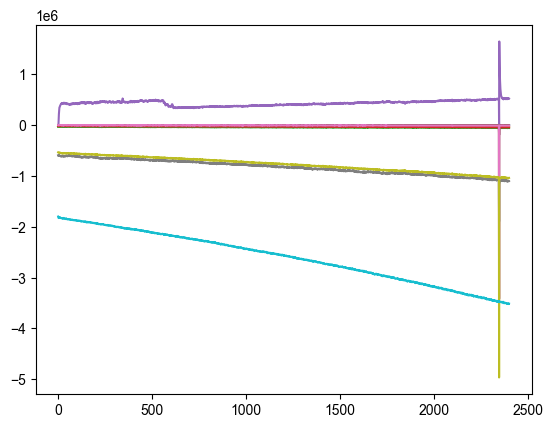

In [66]:
# plot top 10 varied v/e
plt.figure()
plt.plot(v_over_e.iloc[:,arg_sort_variation[-10:]], label = v_over_e.iloc[:,arg_sort_variation[-10:]].columns)
plt.yscale('log')


In [71]:
v_over_e.iloc[:,arg_sort_variation[-10:]]

,RXN-16804,RXN-11811[CCO-CYTOSOL]-AMMONIA/PROTON//AMMONIUM.38. (reverse),RXN-13202,ACECOATRANS-RXN-PROPIONYL-COA/ACET//PROPIONATE/ACETYL-COA.42.,TRANS-RXN-145,1.5.1.20-RXN-5-METHYL-THF/NADP//METHYLENE-THF/NADPH/PROTON.46.,1.5.1.20-RXN-5-METHYL-THF/NAD//METHYLENE-THF/NADH/PROTON.44. (reverse),TRANS-RXN0-474,TRANS-RXN0-545[CCO-PM-BAC-NEG]-CARBON-DIOXIDE//CARBON-DIOXIDE.47. (reverse),maintenance_reaction
0,-0.0,-31807.031807,-33660.033660,-18757.018757,0.000000,-0.0,-0.000000,-5.939606e+05,-5.370485e+05,-1.800347e+06
1,-0.0,-29614.029614,-33275.033275,-20064.020064,0.000000,-0.0,-554.000554,-5.922936e+05,-5.391235e+05,-1.816532e+06
2,-0.0,-30467.030467,-34152.034152,-20523.020523,34488.662835,-0.0,-645.000645,-5.989546e+05,-5.436705e+05,-1.826290e+06
3,-0.0,-31521.031521,-35322.035322,-20219.020219,139056.206772,-0.0,-5266.005266,-6.079066e+05,-5.440515e+05,-1.829620e+06
4,-0.0,-30588.030588,-34821.034821,-20837.020837,215131.753874,-0.0,-67.000067,-6.035986e+05,-5.454085e+05,-1.823037e+06
...,...,...,...,...,...,...,...,...,...,...
2395,-0.0,-45550.045550,-58179.058179,-45030.045030,520201.575369,-0.0,-10613.010613,-1.101956e+06,-1.045293e+06,-3.512951e+06
2396,-0.0,-45767.045767,-57743.057743,-44410.044410,522509.421345,-0.0,-10795.010795,-1.102212e+06,-1.044145e+06,-3.519026e+06
2397,-0.0,-45215.045215,-57193.057193,-43986.043986,525804.959553,-0.0,-10328.010328,-1.100380e+06,-1.041563e+06,-3.521835e+06
2398,-0.0,-44822.044822,-56816.056816,-44059.044059,524358.344280,-0.0,-10945.010945,-1.095577e+06,-1.039832e+06,-3.513413e+06


In [67]:
pd.DataFrame(flux/reaction_catalyst_counts)

,0,1,2,3,4,5,6,7,8,9,...,9348,9349,9350,9351,9352,9353,9354,9355,9356,9357
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.000000,-0.0,-1.800347e+06
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-4165.004165,-0.0,-1.816532e+06
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-4176.004176,-0.0,-1.826290e+06
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,...,0.003333,0.0,0.0,0.0,0.0,0.0,0.0,-4593.004593,-0.0,-1.829620e+06
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-5653.005653,-0.0,-1.823037e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,...,0.002062,0.0,0.0,0.0,0.0,0.0,0.0,-15302.015302,-0.0,-3.512951e+06
2396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-15340.015340,-0.0,-3.519026e+06
2397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,...,0.002058,0.0,0.0,0.0,0.0,0.0,0.0,-15361.015361,-0.0,-3.521835e+06
2398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-15323.015323,-0.0,-3.513413e+06


In [64]:
arg_sort_variation[-10:]

array([2318, 1814, 1915,  537, 7154,   16,   15, 7991, 8071, 9357])

In [65]:
v_over_e[:,arg_sort_variation[-10:]]

array([[      -0.        ,   -31807.03180703,   -33660.03366003, ...,
         -593960.59396059,  -537048.53704854, -1800346.8003468 ],
       [      -0.        ,   -29614.02961403,   -33275.03327503, ...,
         -592293.59229359,  -539123.53912354, -1816531.81653182],
       [      -0.        ,   -30467.03046703,   -34152.03415203, ...,
         -598954.5989546 ,  -543670.54367054, -1826289.82628983],
       ...,
       [      -0.        ,   -45215.04521505,   -57193.05719306, ...,
        -1100380.1003801 , -1041563.04156304, -3521834.52183452],
       [      -0.        ,   -44822.04482204,   -56816.05681606, ...,
        -1095577.0955771 , -1039832.03983204, -3513412.51341251],
       [      -0.        ,   -45647.04564705,   -57902.05790206, ...,
        -1100691.1006911 , -1040594.04059404, -3514048.51404851]])